<a href="https://colab.research.google.com/github/DRA-chaos/Quantum-Convolutional-Neural-Network/blob/main/Using_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit

     |████████████████████████████████| 6.0MB 2.9MB/s 
     |████████████████████████████████| 18.0MB 1.2MB/s 
     |████████████████████████████████| 235kB 38.9MB/s 
     |████████████████████████████████| 215kB 41.2MB/s 
     |████████████████████████████████| 2.1MB 35.9MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
     |████████████████████████████████| 1.5MB 38.1MB/s 
     |████████████████████████████████| 194kB 50.3MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 614kB 30.3MB/s 
     |████████████████████████████████| 3.2MB 34.2MB/s 
     |████████████████████████████████| 6.3MB 38.1MB/s 
  Created wheel for qiskit: filename=qiskit-0.27.0-cp37-none-any.whl size=10505 sha256=43aa85a0091508ebc54fcda3d30d7c87f04879afde19c63371289ffdfc4305b3
  Stored in directory: /root/.cache/pip/wheels/c6/54/d9/f0f711dc20aff31947456951374132d0e23ec527da8c15295d
  Created wheel for python-constraint: filename=python_constraint-1.4.0-py

In [3]:
import numpy as np
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.circuit import Parameter
from qiskit import Aer
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [32]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

In [33]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

In [34]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [8]:
import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
cifar_trainset = datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)


Extracting ./data1/cifar-10-python.tar.gz to ./data1


In [12]:
len(cifar_trainset)

200

In [10]:
from torch.utils.data import DataLoader, random_split

In [30]:
cifar_trainset = datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)


labels = cifar_trainset.targets # get the labels for the data
labels = np.array(labels)

idx1 = np.where(labels == 0) # filter on aeroplanes
idx2 = np.where(labels == 1) # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
n=100

# concatenate the data indices
idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

# create the filtered dataset for our training set
cifar_trainset.targets = labels[idx] 
cifar_trainset.data = cifar_trainset.data[idx]

cifar_trainset, valid = random_split(cifar_trainset,[150,50])

train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size=1, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=1)

Files already downloaded and verified


In [35]:
@torch.no_grad()
def get_all_preds(model, train_loader):
    all_preds = torch.tensor([])
    for batch in train_loader:
        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

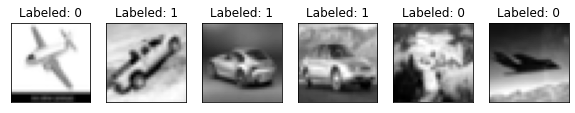

In [37]:
import numpy as np  
import matplotlib.pyplot as plt

n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 2))

while n_samples_show > 0:
    images, targets = data_iter.__next__()
    images=images.squeeze()
  
    axes[n_samples_show - 1].imshow(images[0].numpy(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [38]:
import torchvision
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
cifar_testset = datasets.CIFAR10(root='./data1', train=False, download=True, transform=transform)

labels = cifar_testset.targets # get the labels for the data
labels = np.array(labels)

idx1 = np.where(labels == 0) # filter on aeroplanes
idx2 = np.where(labels == 1) # filter on automobiles

# Specify number of datapoints per class (i.e. there will be n pictures of automobiles and n pictures of aeroplanes in the training set)
n=100

# concatenate the data indices
idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

# create the filtered dataset for our training set
cifar_testset.targets = labels[idx] 
cifar_testset.data = cifar_testset.data[idx]

test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size=1, shuffle=False)

Files already downloaded and verified


In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 500)
        self.fc2 = nn.Linear(500, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

Training [20%]	Loss: -0.4912
Training [40%]	Loss: -0.4945
Training [60%]	Loss: -0.5677
Training [80%]	Loss: -0.6531
Training [100%]	Loss: -0.7011
Performance on test data:
	Loss: -0.6386
	Accuracy: 60.0%


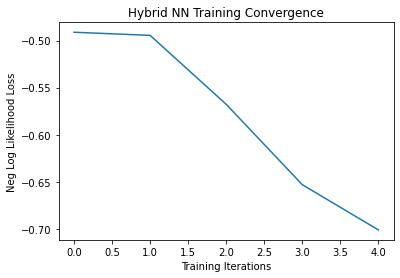

In [43]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 5
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))

#Now plotting the training graph
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )


Training [20%]	Loss: -0.4910
Training [40%]	Loss: -0.4920
Training [60%]	Loss: -0.4908
Training [80%]	Loss: -0.5332
Training [100%]	Loss: -0.5626
Performance on test data:
	Validation Loss: -0.5359
	Accuracy: 50.0%


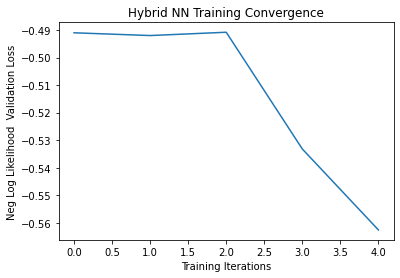

In [44]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 5
loss_list_V = []

model.train()
for epoch in range(epochs):
    valid_loss = []
    for batch_idx, (data, target) in enumerate(valid_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        validation_loss = loss_func(output, target)
        # Backward pass
        validation_loss.backward()
        # Optimize the weights
        optimizer.step()
        
        valid_loss.append(validation_loss.item())
    loss_list_V.append(sum(valid_loss)/len(valid_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list_V[-1]))

#Now plotting the training graph
plt.plot(loss_list_V)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood  Validation Loss')

model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(valid_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        validation_loss = loss_func(output, target)
        valid_loss.append(validation_loss.item())
        
    print('Performance on test data:\n\tValidation Loss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(valid_loss) / len(valid_loss),
        correct / len(valid_loader) * 100)
        )
